#**Forecasting petrol and diesel prices**

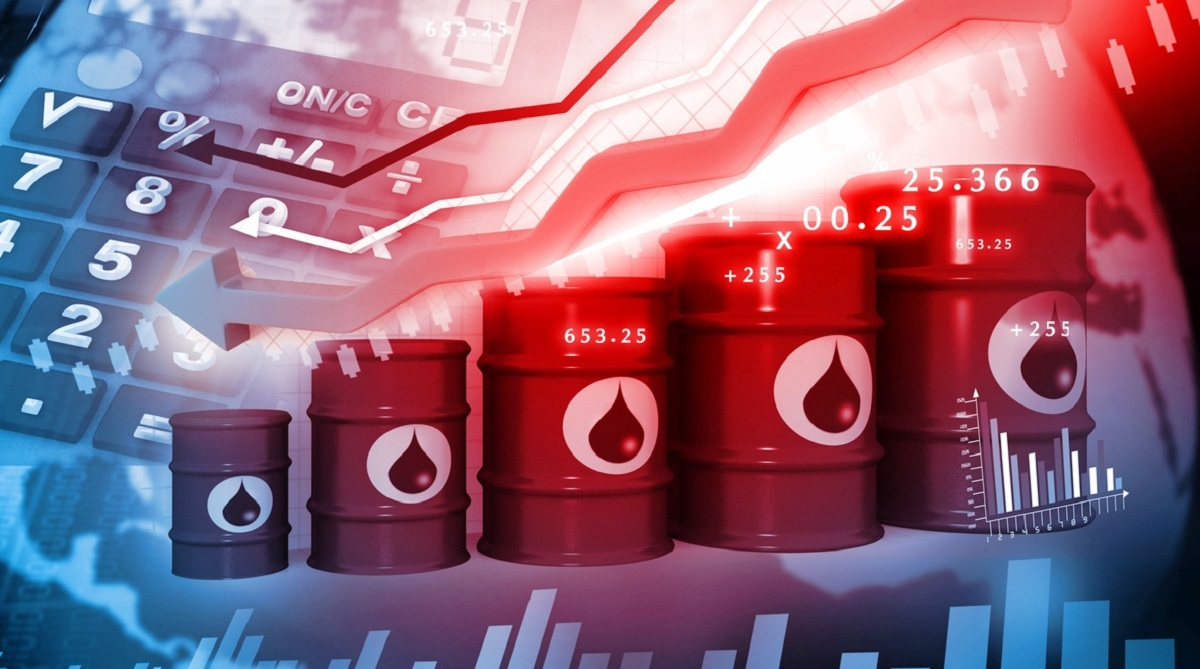

###**Objective:**

The objective of this notebook is to forecast petrol and diesel prices based on historical data.

---



In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import norm, skew
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#reading the data
df=pd.read_excel('PDForecasting.xlsx')
df.head()

,State,Year,Petrol Price (INR/Litre),Diesel Price (INR/Litre)
0,Uttar Pradesh,2021,95,85
1,Uttar Pradesh,2022,97,87
2,Uttar Pradesh,2023,99,89
3,Maharashtra,2021,96,86
4,Maharashtra,2022,98,88


In [ ]:
df.tail()

,State,Year,Petrol Price (INR/Litre),Diesel Price (INR/Litre)
103,Ladakh,2022,99,89
104,Ladakh,2023,101,91
105,Lakshadweep,2021,95,85
106,Lakshadweep,2022,97,87
107,Lakshadweep,2023,99,89


The dataset consist of four columns i.e. State, Year, Petrol price, Diesel price. It consist of yearly prices of Petrol and Diesel in all the states from the year 2021 to 2023 with 108 rows.

---



In [ ]:
df.shape

(108, 4)

Our dataset has 108 rows and 4 columns.

---



In [ ]:
#datatypes
df.dtypes

State                       object
Year                         int64
Petrol Price (INR/Litre)     int64
Diesel Price (INR/Litre)     int64
dtype: object

In [ ]:
df.isna().sum()

State                       0
Year                        0
Petrol Price (INR/Litre)    0
Diesel Price (INR/Litre)    0
dtype: int64

Dataset does not contain null values.

---



<Axes: xlabel='Petrol Price (INR/Litre)', ylabel='Density'>

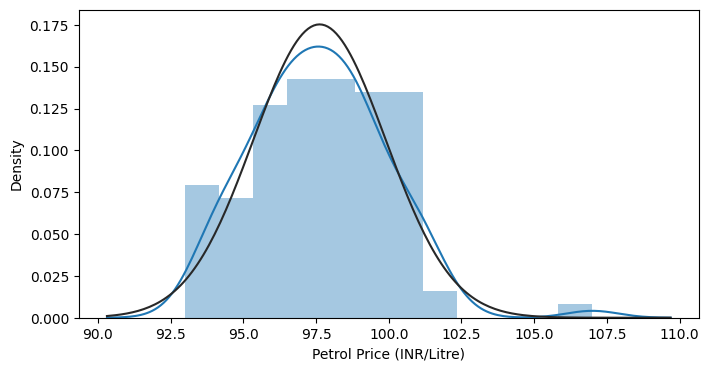

In [ ]:
#check the ditribution of the target variable
from matplotlib import rcParams

rcParams['figure.figsize'] = 8,4

sns.distplot(df['Petrol Price (INR/Litre)'], fit=norm)

- A histogram and KDE plot can help us understand the distribution of a variable, such as PetrolPrices, in our dataset
- We can observe the shape and spread of the distribution, by which we can conclude the range of petrol prices is mostly in between Rs.93 to Rs.101


---



<Axes: xlabel='Diesel Price (INR/Litre)', ylabel='Density'>

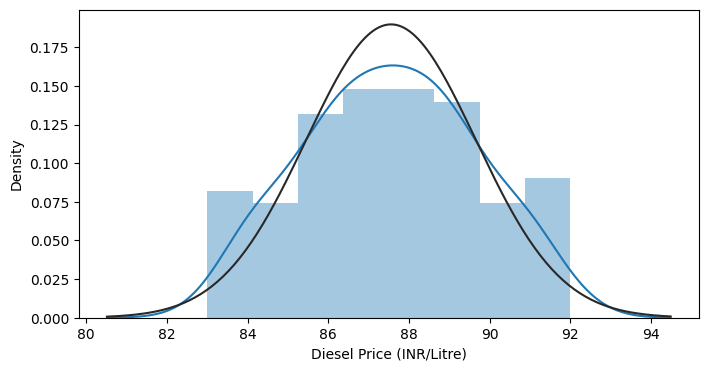

In [ ]:
rcParams['figure.figsize'] = 8,4

sns.distplot(df['Diesel Price (INR/Litre)'], fit=norm)

- A histogram and KDE plot can help us understand the distribution of a variable, such as DieselPrices, in our dataset
- We can observe the shape and spread of the distribution, by which we can conclude the range of diesel prices is likely equally distributed but we can see diesel prices of most of the states are in the range of Rs.85.5 to Rs.90

---



###**Univariate Analysis:**

In [ ]:
# Group data by state and calculate average price
state_avg_price = df.groupby('State')['Petrol Price (INR/Litre)'].mean()

# Print the state-wise average price for the 3-year period
print(state_avg_price)


State
Andaman & Nicobar                        96.000000
Andhra Pradesh                          100.000000
Arunachal Pradesh                        97.000000
Assam                                    99.000000
Bihar                                    96.000000
Chandigarh                               99.000000
Chhattisgarh                             98.000000
Dadra & Nagar Haveli and Daman & Diu     98.000000
Delhi                                    99.000000
Goa                                      99.000000
Gujarat                                  97.000000
Haryana                                  96.000000
Himachal Pradesh                         96.000000
Jammu & Kashmir                          97.000000
Jharkhand                                96.000000
Karnataka                                99.000000
Kerala                                   98.000000
Ladakh                                   99.000000
Lakshadweep                              97.000000
Madhya Pradesh           

In [ ]:
# Group data by state and calculate average price
state_avg_price = df.groupby('State')['Diesel Price (INR/Litre)'].mean()

# Print the state-wise average price for the 3-year period
print(state_avg_price)


State
Andaman & Nicobar                       86.0
Andhra Pradesh                          90.0
Arunachal Pradesh                       87.0
Assam                                   89.0
Bihar                                   86.0
Chandigarh                              89.0
Chhattisgarh                            88.0
Dadra & Nagar Haveli and Daman & Diu    88.0
Delhi                                   89.0
Goa                                     89.0
Gujarat                                 87.0
Haryana                                 86.0
Himachal Pradesh                        86.0
Jammu & Kashmir                         87.0
Jharkhand                               86.0
Karnataka                               89.0
Kerala                                  88.0
Ladakh                                  89.0
Lakshadweep                             87.0
Madhya Pradesh                          85.0
Maharashtra                             88.0
Manipur                                 88.0
Megh

#### Forecasted Petrol Prices for 2024 by State

In [ ]:
df.head()

,State,Year,Petrol Price (INR/Litre),Diesel Price (INR/Litre)
0,Uttar Pradesh,2021,95,85
1,Uttar Pradesh,2022,97,87
2,Uttar Pradesh,2023,99,89
3,Maharashtra,2021,96,86
4,Maharashtra,2022,98,88


In [ ]:
columns_to_drop = ['Diesel Price (INR/Litre)']

In [ ]:
df1=df.copy()
df1.drop(columns=columns_to_drop, inplace=True)
df1.head()

,State,Year,Petrol Price (INR/Litre)
0,Uttar Pradesh,2021,95
1,Uttar Pradesh,2022,97
2,Uttar Pradesh,2023,99
3,Maharashtra,2021,96
4,Maharashtra,2022,98


In [ ]:
# Convert the 'year' column to datetime type
df1['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [ ]:
# Filter data for the years 2021, 2022, 2023
start_year = 2021
end_year = 2023
mask = (df1['Year'].dt.year >= start_year) & (df1['Year'].dt.year <= end_year)
df1_filtered = df1[mask]

In [ ]:
df1_filtered

,State,Year,Petrol Price (INR/Litre)
0,Uttar Pradesh,2021-01-01,95
1,Uttar Pradesh,2022-01-01,97
2,Uttar Pradesh,2023-01-01,99
3,Maharashtra,2021-01-01,96
4,Maharashtra,2022-01-01,98
...,...,...,...
103,Ladakh,2022-01-01,99
104,Ladakh,2023-01-01,101
105,Lakshadweep,2021-01-01,95
106,Lakshadweep,2022-01-01,97


In [ ]:
# Group data by state
df1_grouped = df1_filtered.groupby('State').apply(lambda x: x.reset_index(drop=True))

In [ ]:
df1_grouped

State       Year  Petrol Price (INR/Litre)
State                                                                      
Andaman & Nicobar 0  Andaman & Nicobar 2021-01-01                        94
                  1  Andaman & Nicobar 2022-01-01                        96
                  2  Andaman & Nicobar 2023-01-01                        98
Andhra Pradesh    0     Andhra Pradesh 2021-01-01                        98
                  1     Andhra Pradesh 2022-01-01                       100
...                                ...        ...                       ...
Uttarakhand       1        Uttarakhand 2022-01-01                        98
                  2        Uttarakhand 2023-01-01                       100
West Bengal       0        West Bengal 2021-01-01                        97
                  1        West Bengal 2022-01-01                        99
                  2        West Bengal 2023-01-01                       101

[108 rows x 3 columns]

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Iterate over groups and forecast petrol prices for the year 2024
forecasted_prices = []
for state, group in df1_grouped.groupby(level='State'):
    X = group['Year'].dt.year.values.reshape(-1, 1)
    y = group['Petrol Price (INR/Litre)'].values
    model = LinearRegression()
    model.fit(X, y)
    X_2024 = [[2024]]
    petrol_price_2024 = model.predict(X_2024)
    forecasted_prices.append({'State': state, 'petrol_price_2024': petrol_price_2024[0]})

# Create a DataFrame from the forecasted prices
df1_forecasted = pd.DataFrame(forecasted_prices)

# Print the forecasted prices
print(df1_forecasted)

                                   State  petrol_price_2024
0                      Andaman & Nicobar         100.000000
1                         Andhra Pradesh         104.000000
2                      Arunachal Pradesh         101.000000
3                                  Assam         103.000000
4                                  Bihar         100.000000
5                             Chandigarh         103.000000
6                           Chhattisgarh         102.000000
7   Dadra & Nagar Haveli and Daman & Diu         102.000000
8                                  Delhi         103.000000
9                                    Goa         103.000000
10                               Gujarat         101.000000
11                               Haryana         100.000000
12                      Himachal Pradesh         100.000000
13                       Jammu & Kashmir         101.000000
14                             Jharkhand         100.000000
15                             Karnataka

Here we can see the Forecasted Petrol Prices for 2024 by State


---



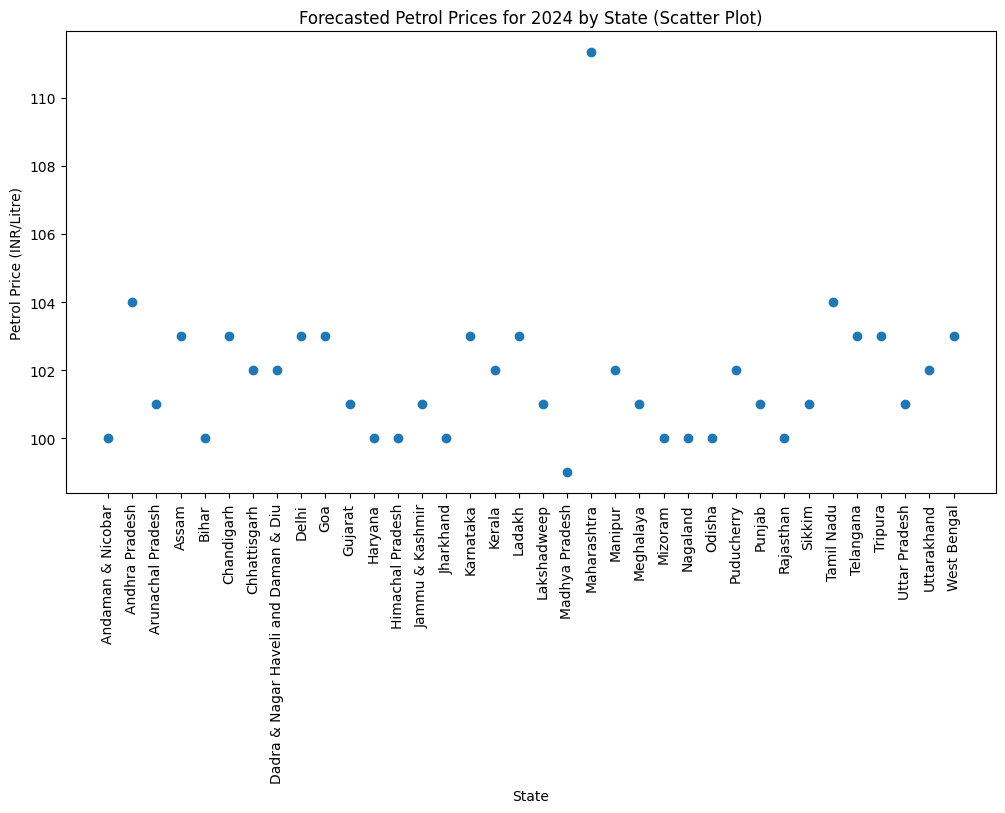

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of forecasted petrol prices
plt.figure(figsize=(12, 6))
plt.scatter(df1_forecasted['State'], df1_forecasted['petrol_price_2024'])
plt.xlabel('State')
plt.ylabel('Petrol Price (INR/Litre)')
plt.title('Forecasted Petrol Prices for 2024 by State (Scatter Plot)')

# Rotate x-axis labels upside down
plt.xticks(rotation='vertical')

plt.show()


Here we can see the distribution of forecasted Petrol prices over the States where we get that all prices are below Rs.104 except the price for Maharashtra State


---



#### Forecasted Diesel Prices for 2024 by State

In [ ]:
df.head()

,State,Year,Petrol Price (INR/Litre),Diesel Price (INR/Litre)
0,Uttar Pradesh,2021,95,85
1,Uttar Pradesh,2022,97,87
2,Uttar Pradesh,2023,99,89
3,Maharashtra,2021,96,86
4,Maharashtra,2022,98,88


In [ ]:
columns_to_drop = ['Petrol Price (INR/Litre)']

In [ ]:
df2=df.copy()
df2.drop(columns=columns_to_drop, inplace=True)
df2.head()

,State,Year,Diesel Price (INR/Litre)
0,Uttar Pradesh,2021,85
1,Uttar Pradesh,2022,87
2,Uttar Pradesh,2023,89
3,Maharashtra,2021,86
4,Maharashtra,2022,88


In [ ]:
# Convert the 'year' column to datetime type
df2['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [ ]:
# Filter data for the years 2021, 2022, 2023
start_year = 2021
end_year = 2023
mask = (df2['Year'].dt.year >= start_year) & (df2['Year'].dt.year <= end_year)
df2_filtered = df2[mask]

In [ ]:
df2_filtered

,State,Year,Diesel Price (INR/Litre)
0,Uttar Pradesh,2021-01-01,85
1,Uttar Pradesh,2022-01-01,87
2,Uttar Pradesh,2023-01-01,89
3,Maharashtra,2021-01-01,86
4,Maharashtra,2022-01-01,88
...,...,...,...
103,Ladakh,2022-01-01,89
104,Ladakh,2023-01-01,91
105,Lakshadweep,2021-01-01,85
106,Lakshadweep,2022-01-01,87


In [ ]:
# Group data by state
df2_grouped = df2_filtered.groupby('State').apply(lambda x: x.reset_index(drop=True))

In [ ]:
df2_grouped

State       Year  Diesel Price (INR/Litre)
State                                                                      
Andaman & Nicobar 0  Andaman & Nicobar 2021-01-01                        84
                  1  Andaman & Nicobar 2022-01-01                        86
                  2  Andaman & Nicobar 2023-01-01                        88
Andhra Pradesh    0     Andhra Pradesh 2021-01-01                        88
                  1     Andhra Pradesh 2022-01-01                        90
...                                ...        ...                       ...
Uttarakhand       1        Uttarakhand 2022-01-01                        88
                  2        Uttarakhand 2023-01-01                        90
West Bengal       0        West Bengal 2021-01-01                        87
                  1        West Bengal 2022-01-01                        89
                  2        West Bengal 2023-01-01                        91

[108 rows x 3 columns]

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Iterate over groups and forecast diesel prices for the year 2024
forecasted_prices = []
for state, group in df2_grouped.groupby(level='State'):
    X = group['Year'].dt.year.values.reshape(-1, 1)
    y = group['Diesel Price (INR/Litre)'].values
    model = LinearRegression()
    model.fit(X, y)
    X_2024 = [[2024]]
    diesel_price_2024 = model.predict(X_2024)
    forecasted_prices.append({'State': state, 'diesel_price_2024': diesel_price_2024[0]})

# Create a DataFrame from the forecasted prices
df2_forecasted = pd.DataFrame(forecasted_prices)

# Print the forecasted prices
print(df2_forecasted)

                                   State  diesel_price_2024
0                      Andaman & Nicobar               90.0
1                         Andhra Pradesh               94.0
2                      Arunachal Pradesh               91.0
3                                  Assam               93.0
4                                  Bihar               90.0
5                             Chandigarh               93.0
6                           Chhattisgarh               92.0
7   Dadra & Nagar Haveli and Daman & Diu               92.0
8                                  Delhi               93.0
9                                    Goa               93.0
10                               Gujarat               91.0
11                               Haryana               90.0
12                      Himachal Pradesh               90.0
13                       Jammu & Kashmir               91.0
14                             Jharkhand               90.0
15                             Karnataka

Here we can see the Forecasted Diesel Prices for 2024 by State


---



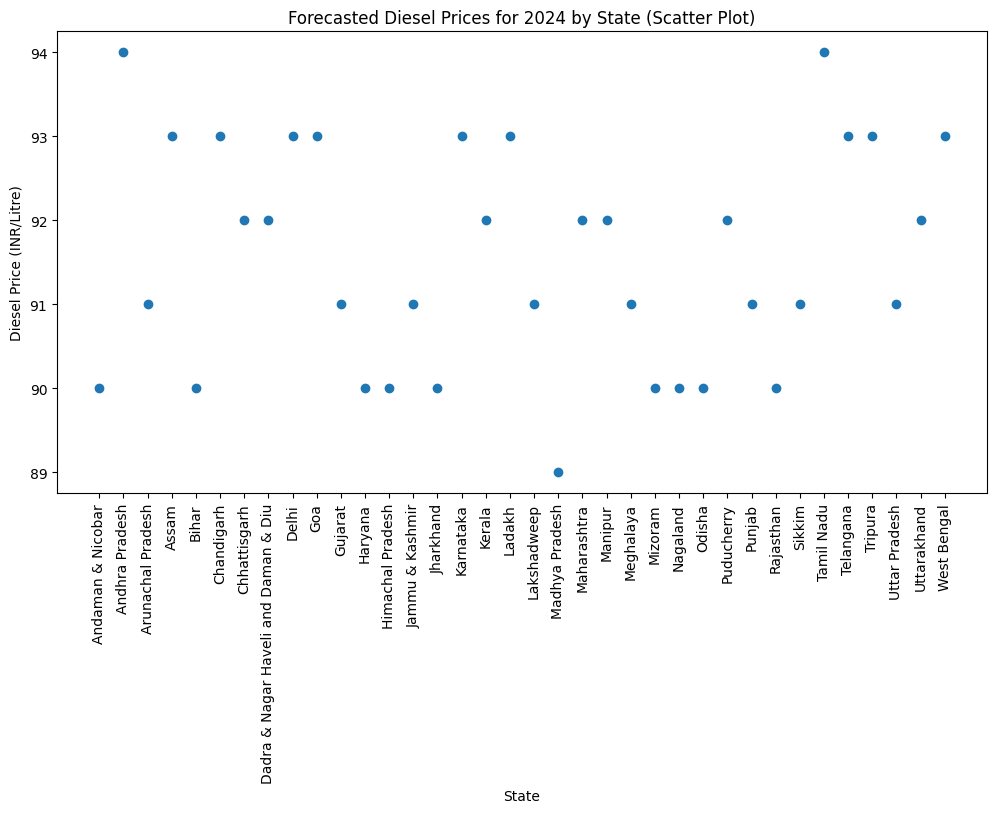

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of forecasted diesel prices
plt.figure(figsize=(12, 6))
plt.scatter(df2_forecasted['State'], df2_forecasted['diesel_price_2024'])
plt.xlabel('State')
plt.ylabel('Diesel Price (INR/Litre)')
plt.title('Forecasted Diesel Prices for 2024 by State (Scatter Plot)')

# Rotate x-axis labels upside down
plt.xticks(rotation='vertical')

plt.show()


Here we can see the distribution of forecasted Diesel prices over the States where we get that all prices are likely equally distributed between the range of Rs.90 to Rs.93 where Madhya Pradesh have the least forecasted price(Rs.89) for 2024 and Andhra Pradesh as well as Tamil Nadu have the highest forecasted price(Rs.94) for 2024


---



###**Conclusion:**

- Here we get the future forecasting of petrol and diesel prices using Linear Regression model.
- By having insight into not only current data but projections of what could happen in the future, businesses can make better adjustments.
- Forecasts help businesses optimise their strategies and alter their current operations to change potential outcomes.

---

